# Interpretting LOL embeddings

In [8]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=1)
PALETTE = sns.color_palette("Set1")

from graspy.plot import pairplot
from lol import LOL
from hyppo.independence import Dcorr
from scipy.stats import multiscale_graphcorr
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import check_X_y

import sys; sys.path.append('../')
from src.tools.utils import get_files, get_latents

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
## Define paths
base_dir = Path("/mnt/ssd3/ronan/data/gcca_05-26-10:39_min_rank-ZG3/")
external_dir = Path('../data/external')
groups, labels = get_latents(base_dir, flag='_gcca')
print(labels)

[['e', 'restingstate'], ['e', 'openmonitoring'], ['e', 'compassion'], ['n', 'restingstate'], ['n', 'openmonitoring'], ['n', 'compassion']]


In [10]:
# RedBu 9
colors = [
    '#b2182b',
    '#d6604d',
    '#f4a582',
    '#92c5de',
    '#4393c3',
    '#2166ac',
]

# Labls
traits = np.concatenate([[l[0]]*len(groups[i]) for i,l in enumerate(labels)])
states = np.concatenate([[l[1]]*len(groups[i]) for i,l in enumerate(labels)])
states_traits = np.concatenate([[l[0] + ' ' + l[1]]*len(groups[i]) for i,l in enumerate(labels)])

In [11]:
def fit_transform(X, y, return_projs=False):
    X, y = check_X_y(
            X,
            y,
            dtype=[np.float64, np.float32],
            ensure_2d=True,
            copy=True,
            y_numeric=True)
    
    means = []
    stds = []
    classes = np.unique(y)
    for group in classes:
        Xg = X[y == group, :]
        means.append(Xg.mean(0))
        stds.append(Xg.std(0))
    
    idx = np.asarray([5,4,3,2,1,0])
    delta = np.asarray(means)[idx]
    
    delta[1:] -= delta[0]
    
    return X @ delta[1:].T, delta[1:].T, np.asarray(stds).T

In [12]:
X = np.vstack(groups)
X = X[:,:,:3].reshape(X.shape[0], -1)
y = np.concatenate([[i]*len(groups[i]) for i in range(len(labels))])
print(X.shape)

(228, 56145)


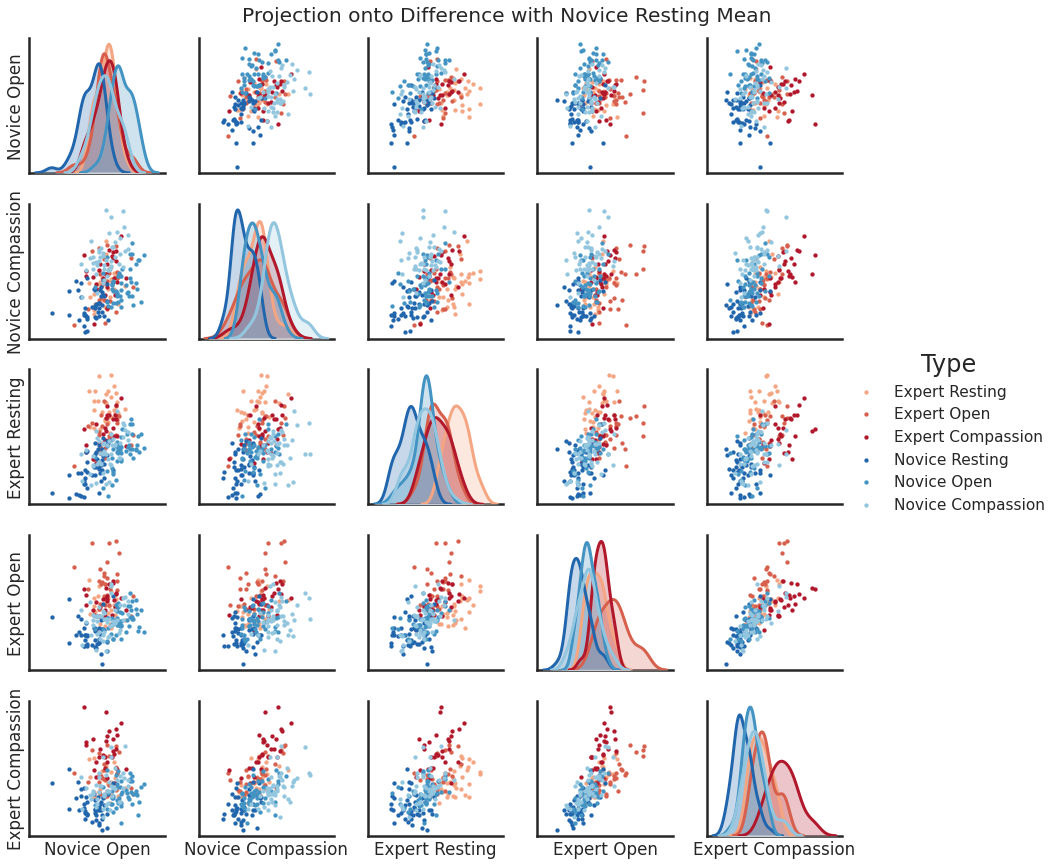

In [13]:
proj, loadings, stds = fit_transform(X, states_traits)
xticklabels = [
    'Novice Open',
    'Novice Compassion',
    'Expert Resting',
    'Expert Open',
    'Expert Compassion',
]
class_labels = {
    'e restingstate':'Expert Resting',
    'e openmonitoring':'Expert Open',
    'e compassion':'Expert Compassion',
    'n restingstate':'Novice Resting',
    'n openmonitoring':'Novice Open',
    'n compassion':'Novice Compassion',
}
proj_labels = [class_labels[st] for st in states_traits]
pairplot(
    proj,
    proj_labels,
    col_names=xticklabels,
    variables=xticklabels,
    palette = {name:col for name,col in zip(np.unique([class_labels[st] for st in states_traits]), colors)},
    title=f'Projection onto Difference with Novice Resting Mean',
    alpha=1.0,
    size=75,
    context='poster',
    font_scale=0.7
    )
#plt.savefig('../reports/ohbm/lol_projections.pdf')

In [287]:
stat, pvalue = Dcorr().test(proj, (y > 3).astype(int), reps=1000)
print(pvalue)

1.7255308612518564e-10


In [288]:
stat, pvalue = Dcorr().test(proj, (y % 3).astype(int), reps=1000)
print(pvalue)

1.5432103695621456e-12


## Plot on brain surface

In [14]:
from nilearn import datasets, plotting
import nibabel as nib
import matplotlib as mpl

In [15]:
# plot on fsa5 surface:
fsa5 = datasets.fetch_surf_fsaverage()

In [16]:
def visualize_embeddings(
    embeddings,
    save_path=False,
    vmax=None,
    symmetric_cbar=True,
    colorbar=False,
    n_embed = 1,
    title = None,
):
    plt.clf()
    res_scale = 2
    fig, axes = plt.subplots(n_embed, 4, subplot_kw={'projection': '3d'}, figsize=(res_scale*5, res_scale*n_embed))
    if n_embed==1:
        axes = [axes]
    
    plt.subplots_adjust(wspace=0, hspace=0)        

    for i,ax in enumerate(axes):
        X = embeddings[:, i]

        cortex_left = nib.freesurfer.read_label(external_dir / 'lh.cortex.label')

        conn_map = np.zeros(10242)
        conn_map[cortex_left] = X[:len(cortex_left)]

        plotting.plot_surf_stat_map(fsa5.infl_left, 
          conn_map, hemi='left', colorbar=False, cmap='RdBu', axes = ax[0],
          vmax=vmax, symmetric_cbar=symmetric_cbar)

        plotting.plot_surf_stat_map(fsa5.infl_left,
          conn_map, hemi='left', colorbar=False, cmap='RdBu', view='medial', axes=ax[1], 
            vmax=vmax,symmetric_cbar=symmetric_cbar)

        cortex_right = nib.freesurfer.read_label(external_dir / 'rh.cortex.label')

        conn_map = np.zeros(10242)
        conn_map[cortex_right] = X[len(cortex_left):]

        plotting.plot_surf_stat_map(fsa5.infl_right, 
          conn_map, hemi='right', colorbar=False, cmap='RdBu', axes = ax[2], 
           vmax=vmax,symmetric_cbar=symmetric_cbar)

        plotting.plot_surf_stat_map(fsa5.infl_right,
          conn_map, hemi='right', colorbar=colorbar, cmap='RdBu', view='medial', axes=ax[3], 
            vmax=vmax,symmetric_cbar=symmetric_cbar)

    if title:
        fig.suptitle(title, fontsize=20, y=0.92)
    if save_path:
        plt.savefig(f'{str(save_path)}.png', format='png', bbox_inches='tight')
    else:
        return fig
#         plt.show()
#         plt.close(fig)
    
def make_cbar(vmax, save_path = None, vmin=None):
    if vmin is None:
        vmin = -vmax
        cmap = mpl.cm.RdBu
    else:
        cmap = mpl.cm.Blues
    fig, ax = plt.subplots(figsize=(1, 15))
    fig.subplots_adjust(bottom=0.5)

    #cmap = mpl.cm.RdBu
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')
    
    #cb1.set_clim(vmin, vmax)
    #cb1.set_label('Some Units')
    if save_path:
        plt.savefig(f'{str(save_path)}.pdf', bbox_inches='tight')
    plt.close(fig)

ValueError: shape mismatch: value array of shape (46791,) could not be broadcast to indexing result of shape (9361,)

<Figure size 432x288 with 0 Axes>

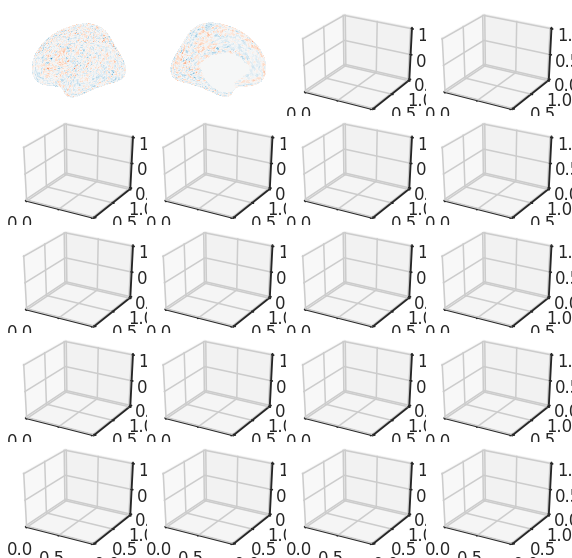

In [17]:
save_dir = Path('../reports/ohbm/differenced_mean_loadings')

## Select Gradient(s)
X = np.vstack(groups)
X = X[:,:,:3].reshape(X.shape[0], -1)
y = np.concatenate([[i]*len(groups[i]) for i in range(len(labels))])

## Project
proj, loadings, stds = fit_transform(X, states_traits)

y_labels = [
    'Novice Open',
    'Novice Compassion',
    'Expert Resting',
    'Expert Open',
    'Expert Compassion',
]

loadings_normalized = loadings / np.sqrt(
    np.concatenate((
        47/(47+47-2)*stds[:,1:3]**2 + 47/(47+47-2)*stds[:,0][:,None]**2,
        29/(47+29-2)*stds[:,3:]**2 + 47/(47+29-2)*stds[:,0][:,None]**2),
    axis=1)
)

vmax = np.max(np.abs(loadings))
## Visualize
visualize_embeddings(
    loadings_normalized,
    save_path=False,
    colorbar=False,
    n_embed=5,
    vmax=vmax,
    title=False,
)
    
#plt.savefig(save_dir / f'loading_deviances_gradient=all.pdf', bbox_inches='tight')

#make_cbar(vmax, save_dir / 'loading_deviances_all_colorbar', bbox_inches='tight')

In [301]:
save_dir = Path('../reports/ohbm/differenced_mean_loadings')

In [299]:
vmax = 0
for i in range(3):
    ## Select Gradient(s)
    X = np.vstack(groups)
    X = X[:,:,i].reshape(X.shape[0], -1)
    y = np.concatenate([[i]*len(groups[i]) for i in range(len(labels))])

    ## Project
    proj, loadings, stds = fit_transform(X, states_traits)
    
    ## Pooled Sample variance. numpy std had ddof=0
    loadings_normalized = loadings / np.sqrt(
        np.concatenate((
            47/(47+47-2)*stds[:,1:3]**2 + 47/(47+47-2)*stds[:,0][:,None]**2,
            29/(47+29-2)*stds[:,3:]**2 + 47/(47+29-2)*stds[:,0][:,None]**2),
        axis=1)
    )
    
    vmax = max(vmax,np.max(np.abs(loadings_normalized)))

<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

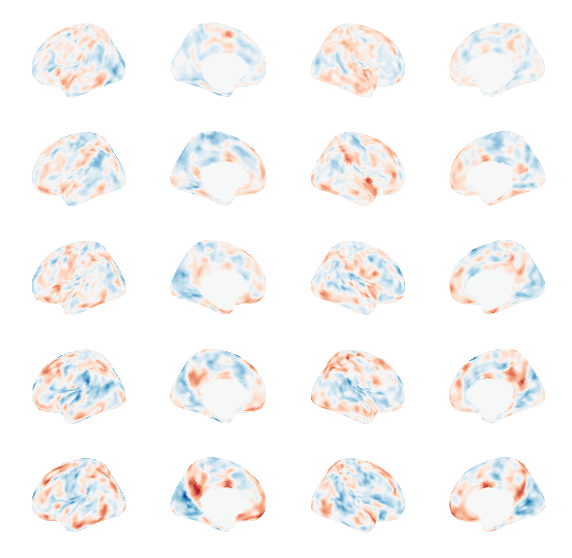

In [303]:
N_VOXELS = 18715

for i in range(3):
    ## Select Gradient(s)
    X = np.vstack(groups)
    X = X[:,:,i].reshape(X.shape[0], -1)
    y = np.concatenate([[i]*len(groups[i]) for i in range(len(labels))])

    ## Project
    proj, loadings, stds = fit_transform(X, states_traits)
    
    ## Pooled Sample variance. numpy std had ddof=0
    loadings_normalized = loadings / np.sqrt(
        np.concatenate((
            47/(47+47-2)*stds[:,1:3]**2 + 47/(47+47-2)*stds[:,0][:,None]**2,
            29/(47+29-2)*stds[:,3:]**2 + 47/(47+29-2)*stds[:,0][:,None]**2),
        axis=1)
    )

    ## Visualize
    visualize_embeddings(
        loadings_normalized,
        save_path=False,
        colorbar=False,
        n_embed=5,
        vmax=vmax,
        title=False,
    )

    plt.savefig(save_dir / f'loading_deviances_gradient={i+1}.pdf', bbox_inches='tight')
    
make_cbar(vmax, save_dir / 'loading_deviances_colorbar')